# Car Damage Classification

## Case Study Overview

In Car Insurance industry, a lot of money is being wasted on Claims leakage. Claims leakage is the gap between the optimal and actual settlement of a claim. Visual inspection and validation are being used to reduce claims leakage. But doing inspection might take a long time and result in delaying of claims processing. An automated system for doing inspection and validation will be of great help in speeding up the process.

## Business Use Case

To reduce Claims leakage, Visual inspection and validation are being done. This takes a long time and we are automating this procedure. Using this automation will result in processing of Claims faster.

## Mapping Real world problem to DL problem

   The Car damage dataset is comprised of 2300 images.Since we are trying to automate the Visual inspection and validation of vehicle damage and in input data all we have are images.
<p>This problem is a classic classification problem.<p>
We will be using Convolutional Neural Networks (CNN).
We are using CNN to predict whether the car has been damaged are not, Where the damage is and the severity of damage.

## Evaluation Metrics

In this we are using Accuracy, Precision, Recall as performance metrics.

To calculate Accuracy, Precision, Recall we need to calculate Confusion matrix.
1. From Confusion matrix we get True Positives(TP), True Negatives(TN), False Positives(FP), False Negatives(FN).
2. Accuracy is given by (TP+TN)/(TP+FP+TN+FN)
3. Precision is given by TP/(TP+FP)
4. Recall is given by TP/(TP+FN)

## Data Source and Overview 

1. Since the dataset for damage in cars are rare. 
2. The car dataset is downloaded from https://www.kaggle.com/anujms/car-damage-detection and https://drive.google.com/drive/folders/1cCOxtyycmNX8hZjmmre1qHSQU76G6hLR
3. This consists of Train and Validation which each folder has Damage cars pics and whole car pics. A total of 2300 images are present in both train and validation.

## Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
import random
from tqdm import tqdm
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping


#Importing required libraries
import os
import json
import urllib
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

# EDA

In [3]:
from google.colab import drive

WORK_DRIVE = '/content/drive'
WORK_AREA = WORK_DRIVE + '/MyDrive/damage detection'

drive.mount(WORK_DRIVE,force_remount=True)


Mounted at /content/drive


In [4]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
os.chdir(WORK_AREA)

We have three types of Datasets:
1. Training and Test folders of Car damaged, not damaged images.
2. Training and Test folders of Damage on Front, Rear, Side.
3. Training and Test folders of Damage severity Minor, Moderate, Severe.

### Data-1

####  Observations:

1. From the test plot we can see that the images we have for Damaged and Not damaged classes are equal.
2. Since the cars datasets are rare the test folder has less number of images.

In [ ]:
def img_shapes(files,path):
    shapes = []
    for i in files:
        img = cv2.imread(path+'/'+i)
        shapes.append(img.shape)
    return shapes

In [ ]:
train_dmg = img_shapes(train_damaged_list,'/content/drive/MyDrive/Car-Damage-Classification-main/car-damage-dataset/data1a/training/00-damage')

In [ ]:
train_no_dmg = img_shapes(train_not_damaged_list,'/content/drive/MyDrive/Car-Damage-Classification-main/car-damage-dataset/data1a/training/01-whole')

In [ ]:
train_df = pd.DataFrame(list(zip(train_dmg,train_no_dmg)),columns = classes)

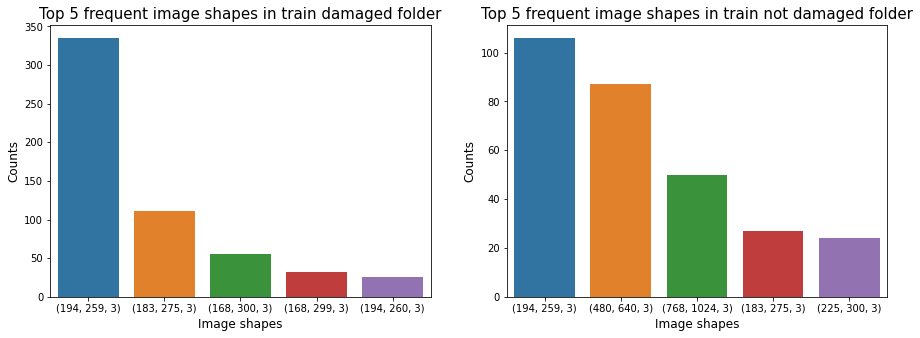

No of unique image shapes in train damaged are  132
No of unique image shapes in train not damaged are  385


In [ ]:
#Damaged train
num = [str(i) for i in train_df['Damaged'].value_counts().index[:5]]
counts_val = [i for i in train_df['Damaged'].value_counts()[:5]]
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sns.barplot(x = num,y =counts_val)
plt.xlabel("Image shapes", fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title("Top 5 frequent image shapes in train damaged folder", fontsize=15)

#Not Damaged train
num = [str(i) for i in train_df['Not Damaged'].value_counts().index[:5]]
counts_val = [i for i in train_df['Not Damaged'].value_counts()[:5]]
plt.subplot(1,2,2)
sns.barplot(x = num,y =counts_val)
plt.xlabel("Image shapes", fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title("Top 5 frequent image shapes in train not damaged folder", fontsize=15)
plt.show()

print('No of unique image shapes in train damaged are ',len(train_df['Damaged'].unique()))
print('No of unique image shapes in train not damaged are ',len(train_df['Not Damaged'].unique()))

####  Observations:

1. From the above plot we can see that the (194,259) image shape are more abudant than others in damaged folder and not damaged folder.
2. But in not damaged folder the counts of images with (194,259) and (480,640) are almost equal.
3. There are 132 unique image shapes present in train damaged folder.
4. There are 385 unique image shapes present in train not damaged folder.

### Data - 2

In [5]:
train_bumper_dent = os.listdir('/content/drive/MyDrive/damage detection/damage/Bumper dent')
train_bumper_scratch = os.listdir('/content/drive/MyDrive/damage detection/damage/Bumper Scratch')
train_crash = os.listdir('/content/drive/MyDrive/damage detection/damage/Crash')
train_door_dent = os.listdir('/content/drive/MyDrive/damage detection/damage/Door Dent')
train_door_scratch = os.listdir('/content/drive/MyDrive/damage detection/damage/Door Scratch')
train_glass_shatter = os.listdir('/content/drive/MyDrive/damage detection/damage/Glass shatter')
train_head_lamp = os.listdir('/content/drive/MyDrive/damage detection/damage/Head lamp')
tarin_tail_lamp=os.listdir('/content/drive/MyDrive/damage detection/damage/Tail lamp')

In [6]:
test_bumper_dent = os.listdir('/content/drive/MyDrive/damage detection/damage/test/bumper_dent')
test_bumper_scratch = os.listdir('/content/drive/MyDrive/damage detection/damage/test/bumper_scratch')
test_crash = os.listdir('/content/drive/MyDrive/damage detection/damage/test/crash')
test_door_dent= os.listdir('/content/drive/MyDrive/damage detection/damage/test/door_dent')
test_door_scratch = os.listdir('/content/drive/MyDrive/damage detection/damage/test/door_scratch')
test_glass_shatter = os.listdir('/content/drive/MyDrive/damage detection/damage/test/glass_shatter')
test_head_lamp = os.listdir('/content/drive/MyDrive/damage detection/damage/test/head_lamp')
test_tail_lamp = os.listdir('/content/drive/MyDrive/damage detection/damage/test/tail_lamp')

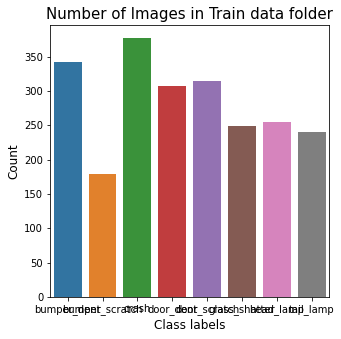

Number of bumper_dent images in train is 342
Number of bumper_scratch images in train is 179
Number of crash images in train is 377
Number of door_dent images in train is 307
Number of door_scratch images in train is 315
Number of glass_shatter images in train is 249
Number of head_lamp images in train is 255
Number of tail_lamp images in train is 240


In [ ]:
classes = ['bumper_dent','bumper_scratch','crash','door_dent','door_scratch','glass_shatter','head_lamp','tail_lamp']
counts = [len(train_bumper_dent),len(train_bumper_scratch),len(train_crash),len(train_door_dent),len(train_door_scratch),len(train_glass_shatter),len(train_head_lamp),len(tarin_tail_lamp)]
plot_bar(classes,counts,'Train data')
for i in range(len(classes)):
    print('Number of '+classes[i]+' images in train is '+str(counts[i]))

####  Observations:

1. From the train plot we can see that the images we have for Front, Rear and Side are not equal.
2. We have more front images and counts of rear and side are almost equal.
3. Since the dataset we have is less we can enlarge the dataset using Data Augmentation.

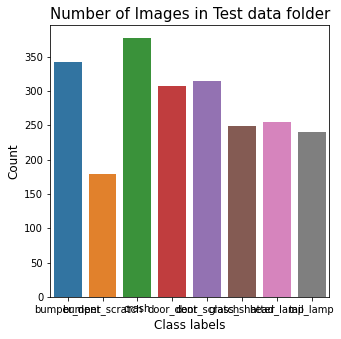

Number of bumper_dent images in test is 342
Number of bumper_scratch images in test is 179
Number of crash images in test is 377
Number of door_dent images in test is 307
Number of door_scratch images in test is 315
Number of glass_shatter images in test is 249
Number of head_lamp images in test is 255
Number of tail_lamp images in test is 240


In [ ]:
classes = ['bumper_dent','bumper_scratch','crash','door_dent','door_scratch','glass_shatter','head_lamp','tail_lamp']
counts = [len(train_bumper_dent),len(train_bumper_scratch),len(train_crash),len(train_door_dent),len(train_door_scratch),len(train_glass_shatter),len(train_head_lamp),len(tarin_tail_lamp)]
plot_bar(classes,counts,'Test data')
for i in range(len(classes)):
    print('Number of '+classes[i]+' images in test is '+str(counts[i]))

####  Observations:

1. From the test plot we can see that the images we have for front, rear and side classes are not equal.
2. Since the cars datasets are rare the test folder has less number of images.

In [ ]:
train_front_shape = img_shapes(train_front,'/content/drive/MyDrive/Car-Damage-Classification-main/car-damage-dataset/data2a/training/00-front')

In [ ]:
train_rear_shape = img_shapes(train_rear,'/content/drive/MyDrive/Car-Damage-Classification-main/car-damage-dataset/data2a/training/01-rear')

In [ ]:
train_side_shape = img_shapes(train_side,'/content/drive/MyDrive/Car-Damage-Classification-main/car-damage-dataset/data2a/training/02-side')

In [ ]:
train_df = pd.DataFrame(list(zip(train_front_shape,train_rear_shape,train_side_shape)),columns = classes)

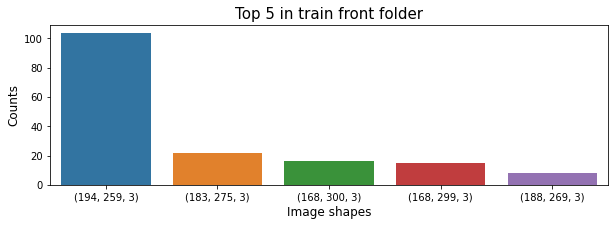

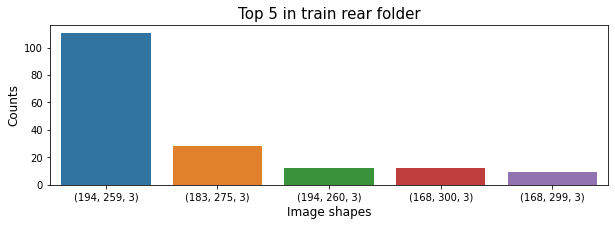

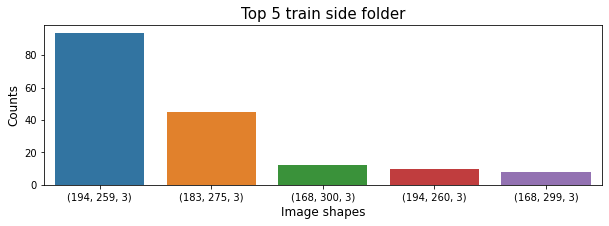

No of unique image shapes in train front are  67
No of unique image shapes in train rear are  68
No of unique image shapes in train side are  60


In [ ]:
#Front train
num = [str(i) for i in train_df['Front'].value_counts().index[:5]]
counts_val = [i for i in train_df['Front'].value_counts()[:5]]
plt.figure(figsize = (10,10))
plt.subplot(3,1,1)
sns.barplot(x = num,y =counts_val)
plt.xlabel("Image shapes", fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title("Top 5 in train front folder", fontsize=15)

#Rear train
plt.figure(figsize = (10,10))
num = [str(i) for i in train_df['Rear'].value_counts().index[:5]]
counts_val = [i for i in train_df['Rear'].value_counts()[:5]]
plt.subplot(3,1,2)
sns.barplot(x = num,y =counts_val)
plt.xlabel("Image shapes", fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title("Top 5 in train rear folder", fontsize=15)
plt.show()

#Side train
plt.figure(figsize = (10,10))
num = [str(i) for i in train_df['Side'].value_counts().index[:5]]
counts_val = [i for i in train_df['Side'].value_counts()[:5]]
plt.subplot(3,1,3)
sns.barplot(x = num,y =counts_val)
plt.xlabel("Image shapes", fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title("Top 5 train side folder", fontsize=15)
plt.show()


print('No of unique image shapes in train front are ',len(train_df['Front'].unique()))
print('No of unique image shapes in train rear are ',len(train_df['Rear'].unique()))
print('No of unique image shapes in train side are ',len(train_df['Side'].unique()))

####  Observations:

1. From the above plot we can see that the (194,259) image shape are more abudant in all classes.
2. There are 70 unique image shapes present in train front folder.
3. There are 67 unique image shapes present in train rear folder.
4. There are 60 unique image shapes present in train side folder.

In this I am creating folders for original data without any augmentation.

**DATA** **WITHOUT** **AUGMENTATION**

In [6]:
lists = [['bumper_dent','bumper_scratch','crash','door_dent','door_scratch','glass_shatter','head_lamp','tail_lamp']]

In [7]:
lists

[['bumper_dent',
  'bumper_scratch',
  'crash',
  'door_dent',
  'door_scratch',
  'glass_shatter',
  'head_lamp',
  'tail_lamp']]

In [8]:
data = ['data_2']

In [9]:
# Parent Directory path
parent_dir = "D:/Pycharm projects/"

paths = []
def create_folders(name,class_lists,data):
    os.mkdir(name)
    for i in range(1):
        os.mkdir(name+'/'+data[i])
        for j in ['train','test']:
            temp_paths = []
            os.mkdir(name+'/'+data[i]+'/'+j)
            for k in class_lists[i]:
                os.mkdir(name+'/'+data[i]+'/'+j+'/'+k)
                temp_paths.append(name+'/'+data[i]+'/'+j+'/'+k)
            paths.append(temp_paths)
    print(paths)
create_folders('data',lists,data)

[['data/data_2/train/bumper_dent', 'data/data_2/train/bumper_scratch', 'data/data_2/train/crash', 'data/data_2/train/door_dent', 'data/data_2/train/door_scratch', 'data/data_2/train/glass_shatter', 'data/data_2/train/head_lamp', 'data/data_2/train/tail_lamp'], ['data/data_2/test/bumper_dent', 'data/data_2/test/bumper_scratch', 'data/data_2/test/crash', 'data/data_2/test/door_dent', 'data/data_2/test/door_scratch', 'data/data_2/test/glass_shatter', 'data/data_2/test/head_lamp', 'data/data_2/test/tail_lamp']]


In [10]:
os.listdir()

['alexnet_stage2_fc-0.762 (1).hdf5',
 'vgg19_stage1_fc-0.907.hdf5',
 'FINAL_REPORT_(1).ipynb',
 'CarAppNewUpdated (1).py',
 'EDA stage 1.ipynb',
 'EDA_stage 2.ipynb',
 'damage',
 'EDA_stage_2_edit.ipynb',
 'model.png',
 'data']

In [11]:
dir = os.getcwd()
print(dir)

/content/drive/MyDrive/damage detection


In [12]:
#Saving images
def save_images(name,save_path,image_path):
    
    #Reading the image from given path.
    image_org = image.load_img(image_path+'/'+name)
    
    #Saving original image to folder.
    image_org.save(save_path+'/'+name)

### Data-1

In [13]:
paths

[['data/data_2/train/bumper_dent',
  'data/data_2/train/bumper_scratch',
  'data/data_2/train/crash',
  'data/data_2/train/door_dent',
  'data/data_2/train/door_scratch',
  'data/data_2/train/glass_shatter',
  'data/data_2/train/head_lamp',
  'data/data_2/train/tail_lamp'],
 ['data/data_2/test/bumper_dent',
  'data/data_2/test/bumper_scratch',
  'data/data_2/test/crash',
  'data/data_2/test/door_dent',
  'data/data_2/test/door_scratch',
  'data/data_2/test/glass_shatter',
  'data/data_2/test/head_lamp',
  'data/data_2/test/tail_lamp']]

In [ ]:
train_save_path_1 = paths[0][0]
train_save_path_2 = paths[0][1]
test_save_path_1 = paths[1][0]
test_save_path_2 = paths[1][1]
print(train_save_path_1)
print(train_save_path_2)
print(test_save_path_1)
print(test_save_path_2)

data/data_1/train/damaged
data/data_1/train/not_damaged
data/data_1/test/damaged
data/data_1/test/not_damaged


### Data-2

In [14]:
train_save_path_1 = paths[0][0]
train_save_path_2 = paths[0][1]
train_save_path_3 = paths[0][2]
train_save_path_4 = paths[0][3]
train_save_path_5 = paths[0][4]
train_save_path_6 = paths[0][5]
train_save_path_7 = paths[0][6]
train_save_path_8 = paths[0][7]
test_save_path_1 = paths[1][0]
test_save_path_2 = paths[1][1]
test_save_path_3 = paths[1][2]
test_save_path_4 = paths[1][3]
test_save_path_5 = paths[1][4]
test_save_path_6 = paths[1][5]
test_save_path_7 = paths[1][6]
test_save_path_8 = paths[1][7]
print(train_save_path_1)
print(train_save_path_2)
print(train_save_path_3)
print(train_save_path_4)
print(train_save_path_5)
print(train_save_path_6)
print(train_save_path_7)
print(train_save_path_8)
print(test_save_path_1)
print(test_save_path_2)
print(test_save_path_3)
print(test_save_path_4)
print(test_save_path_5)
print(test_save_path_6)
print(test_save_path_7)
print(test_save_path_8)

data/data_2/train/bumper_dent
data/data_2/train/bumper_scratch
data/data_2/train/crash
data/data_2/train/door_dent
data/data_2/train/door_scratch
data/data_2/train/glass_shatter
data/data_2/train/head_lamp
data/data_2/train/tail_lamp
data/data_2/test/bumper_dent
data/data_2/test/bumper_scratch
data/data_2/test/crash
data/data_2/test/door_dent
data/data_2/test/door_scratch
data/data_2/test/glass_shatter
data/data_2/test/head_lamp
data/data_2/test/tail_lamp


In [ ]:
for i in tqdm(train_bumper_dent):
    save_images(i,train_save_path_1,'/content/drive/MyDrive/damage detection/damage/Bumper dent')

100%|██████████| 342/342 [01:33<00:00,  3.67it/s]


In [ ]:
for i in tqdm(train_bumper_scratch):
    save_images(i,train_save_path_2,'/content/drive/MyDrive/damage detection/damage/Bumper Scratch')

100%|██████████| 179/179 [00:05<00:00, 34.56it/s]


In [ ]:
for i in tqdm(train_crash):
    save_images(i,train_save_path_3,'/content/drive/MyDrive/damage detection/damage/Crash')

100%|██████████| 377/377 [00:09<00:00, 38.09it/s]


In [ ]:
for i in tqdm(train_door_dent):
  save_images(i,train_save_path_4,'/content/drive/MyDrive/damage detection/damage/Door Dent')

100%|██████████| 307/307 [00:07<00:00, 41.25it/s]


In [ ]:
for i in tqdm(train_door_scratch):
  save_images(i,train_save_path_5,'/content/drive/MyDrive/damage detection/damage/Door Scratch')

100%|██████████| 315/315 [00:08<00:00, 39.27it/s]


In [ ]:
for i in tqdm(train_glass_shatter):
  save_images(i,train_save_path_6,'/content/drive/MyDrive/damage detection/damage/Glass shatter')

100%|██████████| 249/249 [00:07<00:00, 34.76it/s]


In [ ]:
for i in tqdm(train_head_lamp):
  save_images(i,train_save_path_7,'/content/drive/MyDrive/damage detection/damage/Head lamp')

100%|██████████| 255/255 [00:06<00:00, 38.06it/s]


In [ ]:
for i in tqdm(tarin_tail_lamp):
  save_images(i,train_save_path_8,'/content/drive/MyDrive/damage detection/damage/Tail lamp')

100%|██████████| 240/240 [01:00<00:00,  3.94it/s]


In [ ]:
for i in tqdm(test_bumper_dent):
    save_images(i,test_save_path_1,'/content/drive/MyDrive/damage detection/damage/test/bumper_dent')

100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


In [ ]:
for i in tqdm(test_bumper_scratch):
    save_images(i,test_save_path_2,'/content/drive/MyDrive/damage detection/damage/test/bumper_scratch')

100%|██████████| 27/27 [00:06<00:00,  3.98it/s]


In [ ]:
for i in tqdm(test_crash):
    save_images(i,test_save_path_3,'/content/drive/MyDrive/damage detection/damage/test/crash')

100%|██████████| 150/150 [00:41<00:00,  3.58it/s]


In [ ]:
for i in tqdm(test_door_dent):
    save_images(i,test_save_path_4,'/content/drive/MyDrive/damage detection/damage/test/door_dent')

100%|██████████| 70/70 [00:18<00:00,  3.69it/s]


In [ ]:
for i in tqdm(test_door_scratch):
    save_images(i,test_save_path_5,'/content/drive/MyDrive/damage detection/damage/test/door_scratch')

100%|██████████| 125/125 [00:35<00:00,  3.57it/s]


In [ ]:
for i in tqdm(test_glass_shatter):
    save_images(i,test_save_path_6,'/content/drive/MyDrive/damage detection/damage/test/glass_shatter')

100%|██████████| 60/60 [00:14<00:00,  4.04it/s]


In [ ]:
for i in tqdm(test_head_lamp):
    save_images(i,test_save_path_7,'/content/drive/MyDrive/damage detection/damage/test/head_lamp')

100%|██████████| 60/60 [00:15<00:00,  3.93it/s]


In [ ]:
for i in tqdm(test_tail_lamp):
    save_images(i,test_save_path_8,'/content/drive/MyDrive/damage detection/damage/test/tail_lamp')

100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


### Data-3

# Data Augmentation

Since the data we have is less we can synthetically increase the dataset using Data augmentation.I will be using two types of data augmentation as shown below.
1. Enlarging the dataset twice using random rotation between -20 and 20 degrees and horizontal flip transformations.
2. Enlarging the dataset twice using random rotation between -20 and 20, shear-range of 0.2, zoom-range of 0.2 and horizontal-flip.

## Data Augmentation - 1

In this we will use the first type of augmentation and we will visualize for a single image. In this we will create 1 new images for a each image in our data. So the data will enlarge by 2 times.

In [15]:
lists = [['bumper_dent','bumper_scratch','crash','door_dent','door_scratch','glass_shatter','head_lamp','tail_lamp']]

In [16]:
data = ['data_2']

In [17]:
paths = []
def create_folders(name,class_lists,data):
    os.mkdir(name)
    for i in range(1):
        os.mkdir(name+'/'+data[i])
        for j in ['train','test']:
            temp_paths = []
            os.mkdir(name+'/'+data[i]+'/'+j)
            for k in class_lists[i]:
                os.mkdir(name+'/'+data[i]+'/'+j+'/'+k)
                temp_paths.append(name+'/'+data[i]+'/'+j+'/'+k)
            paths.append(temp_paths)
create_folders('data_aug_1',lists,data)

In [18]:
paths

[['data_aug_1/data_2/train/bumper_dent',
  'data_aug_1/data_2/train/bumper_scratch',
  'data_aug_1/data_2/train/crash',
  'data_aug_1/data_2/train/door_dent',
  'data_aug_1/data_2/train/door_scratch',
  'data_aug_1/data_2/train/glass_shatter',
  'data_aug_1/data_2/train/head_lamp',
  'data_aug_1/data_2/train/tail_lamp'],
 ['data_aug_1/data_2/test/bumper_dent',
  'data_aug_1/data_2/test/bumper_scratch',
  'data_aug_1/data_2/test/crash',
  'data_aug_1/data_2/test/door_dent',
  'data_aug_1/data_2/test/door_scratch',
  'data_aug_1/data_2/test/glass_shatter',
  'data_aug_1/data_2/test/head_lamp',
  'data_aug_1/data_2/test/tail_lamp']]

## Data 1

### Visualization

### Generating images and saving in folders

We will be using Validation data in test data. For test data we will be not doing any data augmentation. So we will save these images directly to the folder.

In [19]:
#Creating a function to create images
def create_images(name,save_path,image_path):
    #Generating a random number for rotation
    rotation = random.randint(-20,20)
    #Creating Image Data Generator:
    augmentation = ImageDataGenerator(rotation_range=rotation,horizontal_flip=True)
    
    #Reading the image from given path.
    image_org = image.load_img(image_path+'/'+name)
    
    #Saving original image to folder.
    image_org.save(save_path+'/'+name)
    
    #Getting the numpy array of image.
    image_arr = image.img_to_array(image_org)
    
    #Expanding dimensions of image array
    image_arr = image_arr.reshape((1,) + image_arr.shape)
    
    #Using Flow to generate 2 new images for single image
    for arr,val in zip(augmentation.flow(image_arr, batch_size=1, save_format='jpeg'),range(1)):
        name = name.split('.')[0]
        img_save = image.array_to_img(arr[0], scale=False)
        img_save.save(save_path+'/'+name+'_aug_'+str(val)+'.jpeg')
    return paths

In [20]:
#Saving images
def save_images(name,save_path,image_path):
    
    #Reading the image from given path.
    image_org = image.load_img(image_path+'/'+name)
    
    #Saving original image to folder.
    image_org.save(save_path+'/'+name)

### Data -2

### Visualization

In [22]:
#Getting a sample file name from list of file names
sample_file = random.choice(train_bumper_dent)

In [23]:
#Getting a random rotation between -20 and 20
rotation = random.randint(-20,20)

In [24]:
augmentation = ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,height_shift_range=.2, zoom_range=.2)

In [25]:
sample_img = image.load_img('/content/drive/MyDrive/damage detection/damage/Bumper dent'+'/'+sample_file)

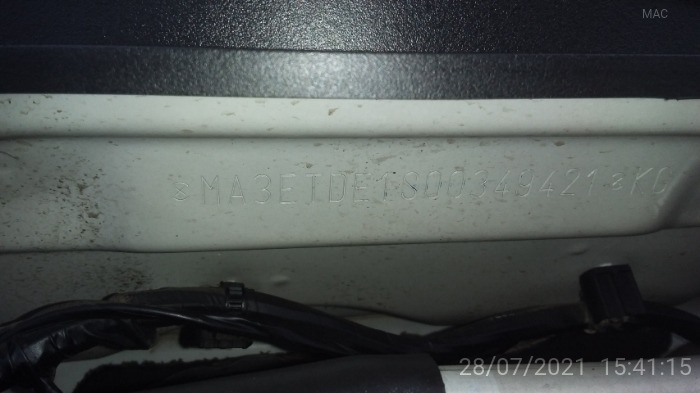

In [26]:
sample_img

In [27]:
sample_img_array = image.img_to_array(sample_img)

In [28]:

sample_img_array = sample_img_array.reshape((1,) + sample_img_array.shape)

In [29]:
samples = []
for arr,val in zip(augmentation.flow(sample_img_array, batch_size=1, save_format='jpg'),range(1)):
    img_save = image.array_to_img(arr[0], scale=False) #scale=False did the trick
    samples.append(img_save)

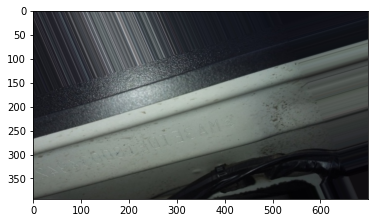

In [30]:
plt.imshow(samples[0])

### Generating images and saving in folders

We will be using Validation data in test data. For test data we will be not doing any data augmentation. So we will save these images directly to the folder.

In [31]:
train_save_path_1 = paths[0][0]
train_save_path_2 = paths[0][1]
train_save_path_3 = paths[0][2]
train_save_path_4 = paths[0][3]
train_save_path_5 = paths[0][4]
train_save_path_6 = paths[0][5]
train_save_path_7 = paths[0][6]
train_save_path_8 = paths[0][7]
test_save_path_1 = paths[1][0]
test_save_path_2 = paths[1][1]
test_save_path_3 = paths[1][2]
test_save_path_4 = paths[1][3]
test_save_path_5 = paths[1][4]
test_save_path_6 = paths[1][5]
test_save_path_7 = paths[1][6]
test_save_path_8 = paths[1][7]
print(train_save_path_1)
print(train_save_path_2)
print(train_save_path_3)
print(train_save_path_4)
print(train_save_path_5)
print(train_save_path_6)
print(train_save_path_7)
print(train_save_path_8)
print(test_save_path_1)
print(test_save_path_2)
print(test_save_path_3)
print(test_save_path_4)
print(test_save_path_5)
print(test_save_path_6)
print(test_save_path_7)
print(test_save_path_8)

data_aug_1/data_2/train/bumper_dent
data_aug_1/data_2/train/bumper_scratch
data_aug_1/data_2/train/crash
data_aug_1/data_2/train/door_dent
data_aug_1/data_2/train/door_scratch
data_aug_1/data_2/train/glass_shatter
data_aug_1/data_2/train/head_lamp
data_aug_1/data_2/train/tail_lamp
data_aug_1/data_2/test/bumper_dent
data_aug_1/data_2/test/bumper_scratch
data_aug_1/data_2/test/crash
data_aug_1/data_2/test/door_dent
data_aug_1/data_2/test/door_scratch
data_aug_1/data_2/test/glass_shatter
data_aug_1/data_2/test/head_lamp
data_aug_1/data_2/test/tail_lamp


In [32]:
#Creating a function to create images
def create_images(name,save_path,image_path):
    #Generating a random number for rotation
    rotation = random.randint(-20,20)
    #Creating Image Data Generator:
    augmentation = ImageDataGenerator(rotation_range=rotation,horizontal_flip=True)
    
    #Reading the image from given path.
    image_org = image.load_img(image_path+'/'+name)
    
    #Saving original image to folder.
    image_org.save(save_path+'/'+name)
    
    #Getting the numpy array of image.
    image_arr = image.img_to_array(image_org)
    
    #Expanding dimensions of image array
    image_arr = image_arr.reshape((1,) + image_arr.shape)
    
    #Using Flow to generate 2 new images for single image
    for arr,val in zip(augmentation.flow(image_arr, batch_size=1, save_format='jpeg'),range(1)):
        name = name.split('.')[0]
        img_save = image.array_to_img(arr[0], scale=False)
        img_save.save(save_path+'/'+name+'_aug_'+str(val)+'.jpeg')
    return paths

In [33]:
#Saving images
def save_images(name,save_path,image_path):
    
    #Reading the image from given path.
    image_org = image.load_img(image_path+'/'+name)
    
    #Saving original image to folder.
    image_org.save(save_path+'/'+name)

In [34]:
for i in tqdm(train_bumper_dent):
    create_images(i,train_save_path_1,'/content/drive/MyDrive/damage detection/damage/Bumper dent')

100%|██████████| 342/342 [02:34<00:00,  2.22it/s]


In [35]:
for i in tqdm(train_bumper_scratch):
    create_images(i,train_save_path_2,'/content/drive/MyDrive/damage detection/damage/Bumper Scratch')

100%|██████████| 179/179 [01:27<00:00,  2.06it/s]


In [36]:
for i in tqdm(train_crash):
    create_images(i,train_save_path_3,'/content/drive/MyDrive/damage detection/damage/Crash')

100%|██████████| 377/377 [02:52<00:00,  2.18it/s]


In [37]:
for i in tqdm(train_door_dent):
  create_images(i,train_save_path_4,'/content/drive/MyDrive/damage detection/damage/Door Dent')

100%|██████████| 307/307 [02:16<00:00,  2.25it/s]


In [38]:

for i in tqdm(train_door_scratch):
  create_images(i,train_save_path_5,'/content/drive/MyDrive/damage detection/damage/Door Scratch')

100%|██████████| 315/315 [02:07<00:00,  2.46it/s]


In [39]:
for i in tqdm(train_glass_shatter):
  create_images(i,train_save_path_6,'/content/drive/MyDrive/damage detection/damage/Glass shatter')

100%|██████████| 249/249 [01:55<00:00,  2.16it/s]


In [40]:
for i in tqdm(train_head_lamp):
  create_images(i,train_save_path_7,'/content/drive/MyDrive/damage detection/damage/Head lamp')

100%|██████████| 255/255 [01:52<00:00,  2.26it/s]


In [41]:
for i in tqdm(tarin_tail_lamp):
  create_images(i,train_save_path_8,'/content/drive/MyDrive/damage detection/damage/Tail lamp')

100%|██████████| 240/240 [02:12<00:00,  1.81it/s]


In [42]:
for i in tqdm(test_bumper_dent):
    create_images(i,test_save_path_1,'/content/drive/MyDrive/damage detection/damage/test/bumper_dent')

100%|██████████| 32/32 [00:10<00:00,  3.20it/s]


In [43]:
for i in tqdm(test_bumper_scratch):
    create_images(i,test_save_path_2,'/content/drive/MyDrive/damage detection/damage/test/bumper_scratch')

100%|██████████| 27/27 [00:10<00:00,  2.59it/s]


In [44]:
for i in tqdm(test_crash):
    create_images(i,test_save_path_3,'/content/drive/MyDrive/damage detection/damage/test/crash')

100%|██████████| 103/103 [00:44<00:00,  2.31it/s]


In [45]:
for i in tqdm(test_door_dent):
    create_images(i,test_save_path_4,'/content/drive/MyDrive/damage detection/damage/test/door_dent')

100%|██████████| 70/70 [00:38<00:00,  1.80it/s]


In [46]:
for i in tqdm(test_door_scratch):
    create_images(i,test_save_path_5,'/content/drive/MyDrive/damage detection/damage/test/door_scratch')

100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


In [47]:
for i in tqdm(test_glass_shatter):
    create_images(i,test_save_path_6,'/content/drive/MyDrive/damage detection/damage/test/glass_shatter')

100%|██████████| 57/57 [00:21<00:00,  2.61it/s]


In [48]:

for i in tqdm(test_head_lamp):
    create_images(i,test_save_path_7,'/content/drive/MyDrive/damage detection/damage/test/head_lamp')

100%|██████████| 60/60 [00:21<00:00,  2.74it/s]


In [49]:

for i in tqdm(test_tail_lamp):
    create_images(i,test_save_path_8,'/content/drive/MyDrive/damage detection/damage/test/tail_lamp')

100%|██████████| 49/49 [00:16<00:00,  2.97it/s]


### Data -3

### Visualization

### Files Counts after Augmentation:

In [ ]:
data_2_files = len(os.listdir('data_augmentation_1/data_2/train/front'))+len(os.listdir('data_augmentation_1/data_2/train/rear'))+len(os.listdir('data_augmentation_1/data_2/train/side'))

In [ ]:
print('Number of files for all classes front,rear,side is ',data_2_files)

Number of files for all classes front,rear,side is  1970


## Data Augmentation - 2

In this we will use the second type of augmentation and we will visualize for a single image. In this we will create 1 new images for a each image in our data. So the data will enlarge by 2 times.

In [ ]:
lists = [['damaged','not_damaged'],['bumper_dent','bumper_scratch','crash','door_dent','door_scratch','glass_shatter','head_lamp','tail_lamp']]

In [ ]:
data = ['data_1','data_2']

In [ ]:
paths = []
def create_folders(name,class_lists,data):
    os.mkdir(name)
    for i in range(2):
        os.mkdir(name+'/'+data[i])
        for j in ['train','test']:
            temp_paths = []
            os.mkdir(name+'/'+data[i]+'/'+j)
            for k in class_lists[i]:
                os.mkdir(name+'/'+data[i]+'/'+j+'/'+k)
                temp_paths.append(name+'/'+data[i]+'/'+j+'/'+k)
            paths.append(temp_paths)
create_folders('data_augmentation_2',lists,data)

## Data 1

### Visualization

In [ ]:
#Getting a sample file name from list of file names
sample_file = random.choice(train_damaged_list)

In [ ]:
#Getting a random rotation between -20 and 20
rotation = random.randint(-20,20)

In [ ]:
augmentation = ImageDataGenerator(rotation_range=rotation, shear_range = 0.2, zoom_range = 0.2, horizontal_flip=True)

In [ ]:
sample_img = image.load_img('/content/drive/MyDrive/Car-Damage-Classification-main/car-damage-dataset/data1a/training/00-damage'+'/'+sample_file)

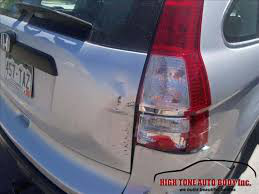

In [ ]:
sample_img

In [ ]:
sample_img_array = image.img_to_array(sample_img)

In [ ]:
sample_img_array = sample_img_array.reshape((1,) + sample_img_array.shape)

In [ ]:
samples = []
for arr,val in zip(augmentation.flow(sample_img_array, batch_size=1, save_format='jpg'),range(1)):
    img_save = image.array_to_img(arr[0], scale=False) #scale=False did the trick
    samples.append(img_save)

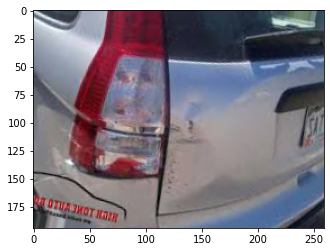

In [ ]:
plt.imshow(samples[0])

### Data -2

### Visualization

In [ ]:
#Getting a sample file name from list of file names
sample_file = random.choice(train_front)

NameError: ignored

In [ ]:
#Getting a random rotation between -20 and 20
rotation = random.randint(-20,20)

In [ ]:
augmentation = ImageDataGenerator(rotation_range=rotation, shear_range = 0.2, zoom_range = 0.2, horizontal_flip=True)

In [ ]:
sample_img = image.load_img('/content/drive/MyDrive/Car-Damage-Classification-main/car-damage-dataset/data2a/training/00-front'+'/'+sample_file)

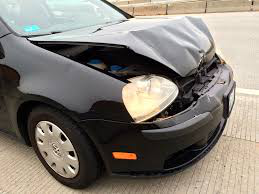

In [ ]:
sample_img

In [ ]:
sample_img_array = image.img_to_array(sample_img)

In [ ]:
sample_img_array = sample_img_array.reshape((1,) + sample_img_array.shape)

In [ ]:
samples = []
for arr,val in zip(augmentation.flow(sample_img_array, batch_size=1, save_format='jpg'),range(1)):
    img_save = image.array_to_img(arr[0], scale=False) #scale=False did the trick
    samples.append(img_save)

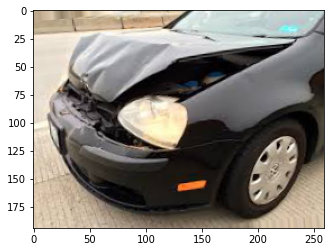

In [ ]:
plt.imshow(samples[0])

### Generating images and saving in folders

We will be using Validation data in test data. For test data we will be not doing any data augmentation. So we will save these images directly to the folder.

In [ ]:
train_save_path_1 = paths[2][0]
train_save_path_2 = paths[2][1]
train_save_path_3 = paths[2][2]
test_save_path_1 = paths[3][0]
test_save_path_2 = paths[3][1]
test_save_path_3 = paths[3][2]
print(train_save_path_1)
print(train_save_path_2)
print(train_save_path_3)
print(test_save_path_1)
print(test_save_path_2)
print(test_save_path_3)

data_augmentation_2/data_2/train/front
data_augmentation_2/data_2/train/rear
data_augmentation_2/data_2/train/side
data_augmentation_2/data_2/test/front
data_augmentation_2/data_2/test/rear
data_augmentation_2/data_2/test/side


In [ ]:
for i in tqdm(train_front):
    create_images(i,train_save_path_1,'/content/drive/MyDrive/Car-Damage-Classification-main/car-damage-dataset/data2a/training/00-front')

100%|██████████| 425/425 [00:20<00:00, 20.73it/s]


In [ ]:
for i in tqdm(train_rear):
    create_images(i,train_save_path_2,'/content/drive/MyDrive/Car-Damage-Classification-main/car-damage-dataset/data2a/training/01-rear')

100%|██████████| 288/288 [00:13<00:00, 21.64it/s]


In [ ]:
for i in tqdm(train_side):
    create_images(i,train_save_path_3,'/content/drive/MyDrive/Car-Damage-Classification-main/car-damage-dataset/data2a/training/02-side')

100%|██████████| 272/272 [00:13<00:00, 19.69it/s]


In [ ]:
for i in tqdm(test_front):
    save_images(i,test_save_path_1,'/content/drive/MyDrive/Car-Damage-Classification-main/car-damage-dataset/data2a/validation/00-front')

100%|██████████| 73/73 [00:00<00:00, 75.44it/s]


In [ ]:
for i in tqdm(test_rear):
    save_images(i,test_save_path_2,'/content/drive/MyDrive/Car-Damage-Classification-main/car-damage-dataset/data2a/validation/01-rear')

100%|██████████| 58/58 [00:00<00:00, 86.94it/s]


In [ ]:
for i in tqdm(test_side):
    save_images(i,test_save_path_3,'/content/drive/MyDrive/Car-Damage-Classification-main/car-damage-dataset/data2a/validation/02-side')

100%|██████████| 48/48 [00:00<00:00, 89.93it/s]


### Data -3

### Visualization

In [ ]:
#Getting a sample file name from list of file names
sample_file = random.choice(train_severe)

In [ ]:
#Getting a random rotation between -20 and 20
rotation = random.randint(-20,20)

In [ ]:
augmentation = ImageDataGenerator(rotation_range=rotation, shear_range = 0.2, zoom_range = 0.2, horizontal_flip=True)

In [ ]:
sample_img = image.load_img('/content/drive/MyDrive/Car-Damage-Classification-main/car-damage-dataset/data3a/training/03-severe'+'/'+sample_file)

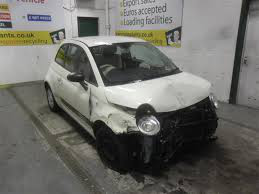

In [ ]:
sample_img

In [ ]:
sample_img_array = image.img_to_array(sample_img)

In [ ]:
sample_img_array = sample_img_array.reshape((1,) + sample_img_array.shape)

In [ ]:
samples = []
for arr,val in zip(augmentation.flow(sample_img_array, batch_size=1, save_format='jpg'),range(1)):
    img_save = image.array_to_img(arr[0], scale=False) #scale=False did the trick
    samples.append(img_save)

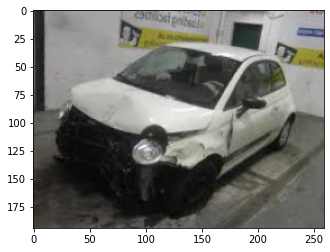

In [ ]:
plt.imshow(samples[0])

### Files Counts after Augmentation:

In [ ]:
data_1_files = len(os.listdir('data_augmentation_2/data_1/train/damaged'))+len(os.listdir('data_augmentation_2/data_1/train/not_damaged'))

In [ ]:
print('Number of files for all classes damaged, not damaged is ',data_1_files)

Number of files for all classes damaged, not damaged is  3700


In [ ]:
data_2_files = len(os.listdir('data_augmentation_2/data_2/train/front'))+len(os.listdir('data_augmentation_2/data_2/train/rear'))+len(os.listdir('data_augmentation_2/data_2/train/side'))

In [ ]:
print('Number of files for all classes front,rear,side is ',data_2_files)

Number of files for all classes front,rear,side is  1970


In [ ]:
data_3_files = len(os.listdir('data_augmentation_2/data_3/train/minor'))+len(os.listdir('data_augmentation_2/data_3/train/moderate'))+len(os.listdir('data_augmentation_2/data_3/train/severe'))

In [ ]:
print('Number of files for all classes minor,moderate,severe is ',data_3_files)

Number of files for all classes minor,moderate,severe is  1958


# Conclusion

We have created three types of data.
1. Original data
2. Original data with augmentation-1
3. Original data with augmentation-2

<p>Since the image shapes we have are different we will use (256,256,3) as default shape when training the CNN.<p>

# VGG19

In [50]:
#Creating a folder to save models
os.mkdir('vgg19')

In [51]:
os.listdir('/content/drive/MyDrive/damage detection/vgg19')

[]

In [13]:
#Creating a funciton which sets layers to non trainable if required
def non_trainable(model):
    for i in range(len(model.layers)):
      model.layers[i].trainable = False
    return model

In [14]:
#Plotting metrics for neural networks models
def plot_metrics(nn_model,metric):
  plt.figure(figsize = (10,5))
  plt.plot(nn_model.history.history[metric])
  plt.plot(nn_model.history.history['val_'+metric])
  plt.title('model '+metric)
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  idx = np.argmax(nn_model.history.history['val_accuracy'])
  print('The '+metric+' for final model is ',nn_model.history.history['val_'+metric][idx])

In [15]:
#Plotting confusion matrix
def binary_confusion_matrix(true_y,pred_y,labels_list):
  Cm = confusion_matrix(true_y,pred_y)
  print("-"*50, "Confusion matrix", "-"*50)
  cmap=sns.light_palette("blue")
  plt.figure(figsize=(10,5))
  sns.heatmap(Cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_list, yticklabels=labels_list)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

In [16]:
def multiclass_confusion_matrix(true_y,pred_y,labels_list):
  Cm = confusion_matrix(true_y,pred_y)
  Pm = (Cm/Cm.sum(axis = 0))
  Rm = (((Cm.T)/(Cm.sum(axis =1))).T)
  cmap = sns.light_palette('blue')
  mt = [Cm,Pm,Rm]
  names = ['Confusion Matrix','Precision Matrix','Recall Matrix']
  print('Average Precision is',np.trace(Pm)/3)
  print('Average Recall is',np.trace(Rm)/3)
  for i in range(len(mt)):
    print('-'*50,names[i],'-'*50)
    plt.figure(figsize = (10,5))
    sns.heatmap(mt[i],annot = True,cmap = cmap,fmt = ".3f",xticklabels = labels_list,yticklabels = labels_list)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [17]:
def compute_precision_recall(true_y,true_pred):
  tp,fn,fp,tn = confusion_matrix(true_y,true_pred).ravel()
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  return precision,recall

In [18]:
vgg19_scores = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall'])

In [19]:
#Data for Neural Networks
input_shapes = (256,256,3)
batch_size = 64

In [20]:
#Classes
stage2_class_labels = ['bumper_dent','bumper_scratch','crash','door_dent','door_scratch','glass_shatter','head_lamp','tail_lamp']

VGG19

In [60]:
##Baseline model

In [21]:
def model_features(model,train_dir,test_dir):
    train_gen = ImageDataGenerator()
    test_gen = ImageDataGenerator()
    
    train_fd = train_gen.flow_from_directory(train_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    test_fd = test_gen.flow_from_directory(test_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    
    train_features = model.predict(train_fd)
    test_features = model.predict(test_fd)
    
    return train_features,test_features,train_fd,test_fd

In [22]:
def target_feat(fd_class):
    temp_dict = dict(fd_class.class_indices)
    keys = list(temp_dict.keys())
    values = list(temp_dict.values())
    
    y = [keys[values.index(i)] for i in fd_class.classes]
    
    return y

In [23]:
#Importing vgg19 model and setting layers as non trainable
vgg19 = applications.VGG19(include_top = False,weights = 'imagenet',input_shape=(256,256,3))
vgg19 = non_trainable(vgg19)
fc = Flatten()(vgg19.output)
model_vgg19 = Model(inputs = vgg19.input,outputs = fc)

In [24]:
train_data_dir = 'data_aug_1/data_2/train'
test_data_dir = 'data_aug_1/data_2/test'

In [25]:
#train_feat,test_feat,train_fd,test_fd = model_features(model_vgg19,train_data_dir, test_data_dir)


train_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()
   


#return train_features,test_features,train_fd,test_fd

In [26]:
train_fd = train_gen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)
test_fd = test_gen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    

Found 4527 images belonging to 8 classes.
Found 1045 images belonging to 8 classes.


In [67]:
train_feat = model_vgg19.predict(train_fd)


4527/4527 [==============================] - 4648s 1s/step


In [68]:
test_feat = model_vgg19.predict(test_fd)

1045/1045 [==============================] - 1136s 1s/step


In [70]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [71]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [72]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 14%|█▍        | 1/7 [02:03<12:22, 123.70s/it]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

Accuracy for alpha 0.0001 is  0.7737306843267108
Accuracy for alpha 0.001 is  0.7693156732891833
Accuracy for alpha 0.01 is  0.7516556291390728
Accuracy for alpha 0.1 is  0.7439293598233996
Accuracy for alpha 1 is  0.7472406181015453
Accuracy for alpha 10 is  0.7461368653421634
Accuracy for alpha 100 is  0.7406181015452539


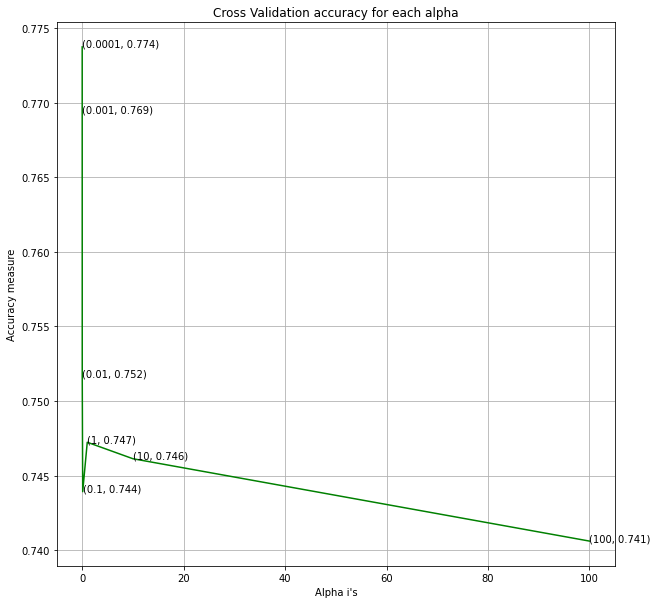

In [73]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

In [86]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model
save_path = 'vgg19/vgg19_stage2_baseline.hdf5'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
precision,recall = compute_precision_recall(y_test,predict_y)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_test,predict_y,stage2_class_labels)

Accuracy on test data for final baseline model 0.5799043062200957


ValueError: ignored

In [66]:
def multiclass_confusion_matrix(true_y,pred_y,labels_list):
  Cm = confusion_matrix(true_y,pred_y)
  Pm = (Cm/Cm.sum(axis = 0))
  Rm = (((Cm.T)/(Cm.sum(axis =1))).T)
  cmap = sns.light_palette('blue')
  mt = [Cm,Pm,Rm]
  names = ['Confusion Matrix','Precision Matrix','Recall Matrix']
  print('Average Precision is',np.trace(Pm)/3)
  print('Average Recall is',np.trace(Rm)/3)
  for i in range(len(mt)):
    print('-'*50,names[i],'-'*50)
    plt.figure(figsize = (10,5))
    sns.heatmap(mt[i],annot = True,cmap = cmap,fmt = ".3f",xticklabels = labels_list,yticklabels = labels_list)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [67]:
multiclass_confusion_matrix(y_test,predict_y,stage2_class_labels)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-67-12242e809c17>", line 1, in <module>
    multiclass_confusion_matrix(y_test,predict_y,stage2_class_labels)
NameError: name 'predict_y' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/py

NameError: ignored

In [ ]:
vgg19_scores = vgg19_scores.append({'Model':'Vgg19_stage1_baseline','Accuracy':'0.930','Precision':'0.927','Recall':'0.935'},ignore_index= True)

In [ ]:
vgg19_scores = vgg19_scores.append({'Model':'Vgg19_stage2_baseline','Accuracy':'0.732','Precision':'0.746','Recall':'0.730'},ignore_index= True)

In [ ]:
vgg19_scores = vgg19_scores.append({'Model':'Vgg19_stage3_baseline','Accuracy':'0.656','Precision':'0.641','Recall':'0.646'},ignore_index= True)

### CNN (Training FC layers only)

## stage 1

In [27]:
def create_model(n_classes,output_activation):
    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()

    ## Set the random seed values to regenerate the model.
    np.random.seed(0)
    rn.seed(0)

    #Input layer
    input_layer = Input(shape=(256,256,3),name='Input_Layer')

    #Adding pretrained model
    vgg19 = applications.VGG19(include_top = False,weights = 'imagenet',input_tensor = input_layer)
    vgg19 = non_trainable(vgg19)

    #Flatten
    flatten = Flatten(data_format='channels_last',name='Flatten')(vgg19.output)
    droupout = Dropout(0.5)(flatten)
    #FC layer
    FC1 = Dense(units=512,activation='LeakyReLU',name='FC1')(droupout)
    droupout = Dropout(0.5)(FC1)
    
    #FC layer
    FC2 = Dense(units=256,activation='LeakyReLU',name='FC2')(droupout)
    droupout = Dropout(0.5)(FC1)
    #Dropout layer
    
    
    #output layer
    Out = Dense(units=n_classes,activation=output_activation,name='Output')(droupout)

    #Creating the Model
    model = Model(inputs=input_layer,outputs=Out)

    return model

## stage 2


In [28]:
model = create_model(8,'softmax')

In [29]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,), metrics=["accuracy"])

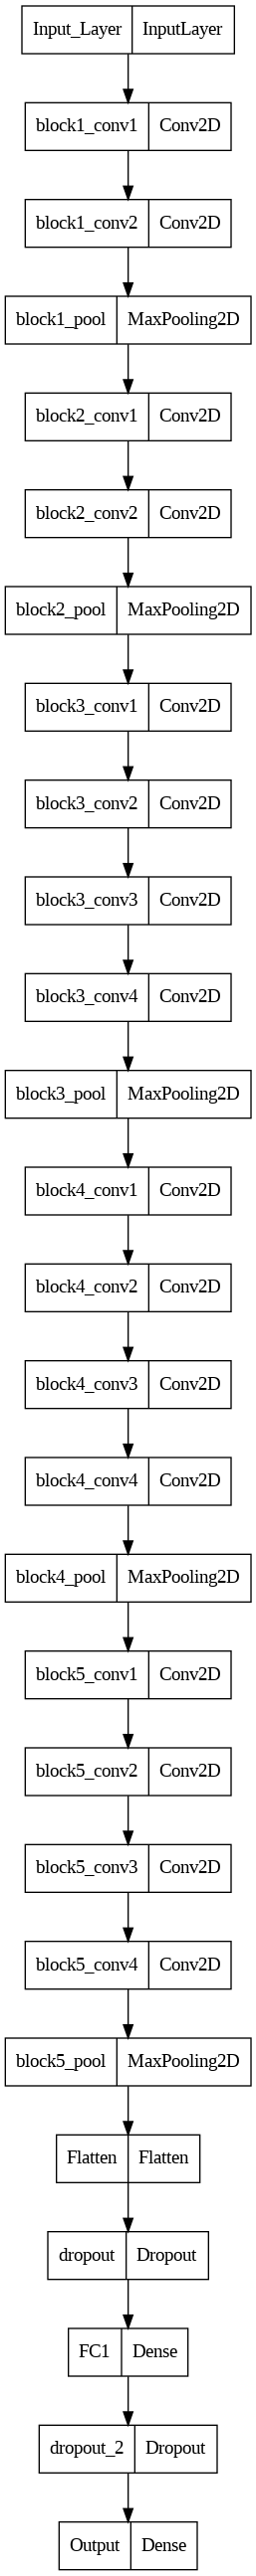

In [30]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [31]:
#Model saving based on validation accuracy score
filepath="vgg_19/vgg19_stage2_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [32]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [33]:
train_data_dir = 'data_aug_1/data_2/train'
test_data_dir = 'data_aug_1/data_2/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 1045/batch_size
n_steps_epoch = 4527/batch_size

Found 4527 images belonging to 8 classes.
Found 1045 images belonging to 8 classes.


In [34]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=15,callbacks=[checkpoint])

Epoch 1/15
71/70 [==============================] - ETA: -18s - loss: 55.2622 - accuracy: 0.4911
Epoch 1: val_accuracy improved from -inf to 0.51100, saving model to vgg_19/vgg19_stage2_fc-0.511.hdf5
70/70 [==============================] - 6045s 86s/step - loss: 55.2622 - accuracy: 0.4911 - val_loss: 52.6913 - val_accuracy: 0.5110
Epoch 2/15
71/70 [==============================] - ETA: -18s - loss: 19.7495 - accuracy: 0.7760
Epoch 2: val_accuracy improved from 0.51100 to 0.53397, saving model to vgg_19/vgg19_stage2_fc-0.534.hdf5
70/70 [==============================] - 5976s 85s/step - loss: 19.7495 - accuracy: 0.7760 - val_loss: 56.3783 - val_accuracy: 0.5340
Epoch 3/15
71/70 [==============================] - ETA: -17s - loss: 14.9152 - accuracy: 0.8315
Epoch 3: val_accuracy did not improve from 0.53397
70/70 [==============================] - 5876s 83s/step - loss: 14.9152 - accuracy: 0.8315 - val_loss: 63.5830 - val_accuracy: 0.5072
Epoch 4/15
71/70 [=============================

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-c57479cacac5>", line 1, in <module>
    model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=15,callbacks=[checkpoint])
  File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.UnknownError: Graph execution error:

OSError: [Errno 107] Transport endpoint is not connected: 'data_aug_1/data_2/train/head_lamp/1260.jpeg'
Traceback (most recent call last):

  File "/usr/local/

UnknownError: ignored

In [ ]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [ ]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

In [ ]:
best_model = load_model('vgg19/vgg19_stage2_fc-0.626.hdf5')


In [ ]:
os.listdir('content/drive/MyDrive/Car-Damage-Classification-main/vgg19')

FileNotFoundError: ignored

In [ ]:
y_pred = best_model.predict(x_test)

In [ ]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('front')
  elif n== 1:
    y_predicted.append('rear')
  elif n == 2:
    y_predicted.append('side')

In [ ]:
multiclass_confusion_acmatrix(y_true,y_predicted,stage2_class_labels)

In [ ]:
vgg19_scores = vgg19_scores.append({'Model':'Vgg19_stage2 FC','Accuracy':'0.693','Precision':'0.710','Recall':'0.678'},ignore_index= True)

## stage 3


In [ ]:
model = create_model(3,'softmax')

In [ ]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
#Model saving based on validation accuracy score
filepath="vgg19/vgg19_stage3_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [ ]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [ ]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 171/batch_size
n_steps_epoch = 1958/batch_size

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [ ]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=3,callbacks=[checkpoint])

Epoch 1/3
245/244 [==============================] - ETA: -1s - loss: 6.1907 - accuracy: 0.4872
Epoch 1: val_accuracy improved from -inf to 0.55556, saving model to vgg19/vgg19_stage3_fc-0.556.hdf5
244/244 [==============================] - 1822s 7s/step - loss: 6.1907 - accuracy: 0.4872 - val_loss: 2.4449 - val_accuracy: 0.5556
Epoch 2/3
245/244 [==============================] - ETA: -1s - loss: 1.2650 - accuracy: 0.7686
Epoch 2: val_accuracy improved from 0.55556 to 0.57310, saving model to vgg19/vgg19_stage3_fc-0.573.hdf5
244/244 [==============================] - 1797s 7s/step - loss: 1.2650 - accuracy: 0.7686 - val_loss: 2.1252 - val_accuracy: 0.5731
Epoch 3/3
245/244 [==============================] - ETA: -1s - loss: 0.6274 - accuracy: 0.8534
Epoch 3: val_accuracy did not improve from 0.57310
244/244 [==============================] - 1790s 7s/step - loss: 0.6274 - accuracy: 0.8534 - val_loss: 2.0229 - val_accuracy: 0.5439


In [ ]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 171 images belonging to 3 classes.


In [ ]:
best_model = load_model('vgg19/vgg19_stage3_fc-0.573.hdf5')

## CNN (Training All layers only)




In [ ]:
def create_model(n_classes,output_activation):
    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()

    ## Set the random seed values to regenerate the model.
    np.random.seed(0)
    rn.seed(0)

    #Input layer
    input_layer = Input(shape=(256,256,3),name='Input_Layer')

    #Adding pretrained model
    vgg19 = applications.VGG19(include_top = False,weights = 'imagenet',input_tensor = input_layer)

    #Flatten
    flatten = Flatten(data_format='channels_last',name='Flatten')(vgg19.output)

    #FC layer
    FC1 = Dense(units=512,activation='relu',name='FC1')(flatten)

    #FC layer
    FC2 = Dense(units=256,activation='relu',name='FC2')(FC1)

    #Dropout layer
    droput1 = Dropout(0.5)(FC2)

    #output layer
    Out = Dense(units=n_classes,activation=output_activation,name='Output')(droput1)

    #Creating the Model
    model = Model(inputs=input_layer,outputs=Out)

    return model

## stage 1

In [ ]:
model = create_model(1,'sigmoid')

In [ ]:
#Compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [ ]:
#Model saving based on validation accuracy score
filepath="vgg19/vgg19_stage1_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [ ]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")

n_validation_steps = 460/batch_size
n_steps_epoch = 3680/batch_size

Found 3700 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [ ]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=3,callbacks=[checkpoint])

Epoch 1/3
460/460 [==============================] - ETA: 0s - loss: 0.7070 - accuracy: 0.7837 
Epoch 1: val_accuracy improved from -inf to 0.88696, saving model to vgg19/vgg19_stage1_all-0.887.hdf5
460/460 [==============================] - 11563s 25s/step - loss: 0.7070 - accuracy: 0.7837 - val_loss: 0.2846 - val_accuracy: 0.8870
Epoch 2/3
 30/460 [>.............................] - ETA: 2:51:42 - loss: 0.3609 - accuracy: 0.8250

In [ ]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1, class_mode = "binary",shuffle = False)

In [ ]:
best_model = load_model('vgg19/vgg19_stage1_all-0.946.hdf5')

## stage 2

In [ ]:
model = create_model(3,'softmax')

In [ ]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [ ]:
#Model saving based on validation accuracy score
filepath="vgg19/vgg19_stage2_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [ ]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [ ]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 179/batch_size
n_steps_epoch = 1970/batch_size

In [ ]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=3,callbacks=[checkpoint])

In [ ]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)